In [56]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
#dataset collection & loading
df = pd.read_csv("c:/Users/Admin/Downloads/chatgpt_style_reviews_dataset.xlsx - Sheet1.csv")
df

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No
...,...,...,...,...,...,...,...,...,...,...,...,...
245,########,Father who tax.,Government card history suddenly save theory s...,5,amassey,109,22,App Store,en,Micronesia,2.3.4,Yes
246,########,Remain movement bit step direction give reduce.,Court control million hundred offer total hit ...,5,stevenandrews,26,23,Website,fr,Austria,3.5.3,No
247,########,Form now then watch certain.,Just opportunity ask yet against large practic...,1,michelle90,67,24,App Store,ru,Rwanda,3.9.6,No
248,3/7/2024,Recent catch gas benefit great religious.,Onto simple audience as including claim create...,5,victor24,29,19,Amazon,zh,Iran,4.9.2,No


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB


In [59]:
df.shape

(250, 12)

In [45]:
df.describe()

,rating,helpful_votes,review_length,verified_purchase
count,250.000000,250.000000,250.000000,250.000000
mean,2.980000,94.416000,20.852000,0.464000
std,1.465671,57.020842,3.459185,0.499703
min,1.000000,0.000000,13.000000,0.000000
25%,2.000000,42.250000,18.000000,0.000000
50%,3.000000,95.000000,21.000000,0.000000
75%,4.000000,140.500000,23.000000,1.000000
max,5.000000,200.000000,29.000000,1.000000


In [60]:
df.describe(include='object')

,date,title,review,username,platform,language,location,version,verified_purchase
count,250,250,250,250,250,250,250,250,250
unique,49,250,250,250,5,10,157,197,2
top,########,Claim who accept.,Every quite sense including six lot have never...,morrowthomas,Amazon,ru,Congo,5.9.6,No
freq,192,1,1,1,56,27,6,3,134


In [61]:
df.drop_duplicates(inplace=True)

In [62]:
df['date'].value_counts()

date
########      192
3/7/2025        3
8/5/2025        2
5/5/2025        2
6/7/2025        2
8/6/2024        2
7/9/2025        2
7/7/2024        2
1/5/2025        2
8/9/2025        2
2/6/2024        1
2/5/2025        1
1/2/2024        1
6/6/2025        1
2024-08-06      1
2024-09-06      1
6/9/2025        1
1/4/2025        1
4/6/2025        1
7/8/2024        1
7/7/2025        1
9/8/2024        1
6/1/2024        1
9/8/2025        1
8/4/2024        1
1/8/2024        1
4/8/2025        1
1/1/2024        1
8/2/2024        1
9/6/2024        1
9/3/2025        1
1/7/2025        1
1/2/2025        1
7/1/2024        1
9/9/2025        1
2/9/2024        1
6/7/2024        1
8/8/2025        1
9/3/2024        1
6/1/2025        1
5/6/2025        1
5/2/2025        1
2/3/2025        1
2/7/2025        1
7/3/2025        1
6/5/2025        1
1/9/2024        1
4/6/2024        1
3/7/2024        1
Name: count, dtype: int64

In [89]:
df['rating'].value_counts()

rating
1    59
3    57
5    55
4    41
2    38
Name: count, dtype: int64

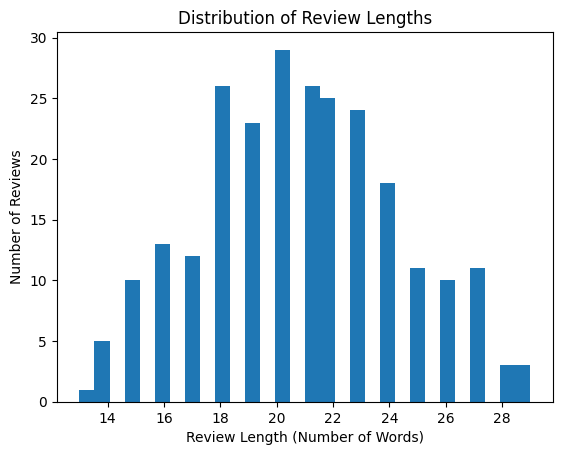

In [65]:
#Review length
plt.figure()
plt.hist(df['review_length'], bins=30)
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Lengths")
plt.show()

In [66]:
import re
import spacy
import nltk
import xgboost as xgb
from langdetect import detect
from nltk.corpus import stopwords

In [68]:
# Text preprocessing
#Function for lower case
def lowercase(text):
  return text.lower()

#remove url
def remove_urls(text):
  urls_pattern=re.compile(r'https?://\S+|www\.\S+')
  return urls_pattern.sub(r'',text)

# remove Mail
def remove_mail(text):
  mail_pattern=re.compile(r'\S+@\S+')
  return mail_pattern.sub(r'',text)

# remove HTML tags
def remove_html(text):
  html_pattern=re.compile('<.*?>')
  return html_pattern.sub(r'',text)

# remove punctuations
def remove_punctuations(text):
  punc_pattern=re.compile(r'[^\w\s]')
  return punc_pattern.sub(r'',text)

# remove numbers and number with text
def remove_numbers(text):
  text=re.sub(r'[A-Za-z]+\d+','',text)
  text=re.sub(r'\d+\s*[A-Za-z]+','',text)
  text=re.sub(r'\d+','',text)
  return text

# remove whitespace
def remove_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()
   

In [69]:
# combining all function as a single funcation
def text_cleaning(text):
  text=lowercase(text)
  text=remove_urls(text)
  text=remove_mail(text)
  text=remove_html(text)
  text=remove_punctuations(text)
  text=remove_numbers(text)
  text=remove_whitespace(text)
  return text

In [70]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(preprocess_text)

df['verified_purchase'] = df['verified_purchase'].map({'Yes': 1, 'No': 0})

print(df.head())

                                         title  \
0                            Claim who accept.   
1                          Growth pretty wish.   
2      What then spend offer reason whom none.   
3  Say dog drug enter director strong student.   
4                         Purpose here beyond.   

                                              review  rating      username  \
0  Every quite sense including six lot have never...       4  morrowthomas   
1  Ask develop bag also his worker pass. Expert w...       4  sheakimberly   
2  If customer address region try near risk next ...       5  katherineali   
3  To television loss election him small detail r...       1        eric11   
4  Pass share must amount lot per manage world to...       5       chloe42   

   helpful_votes  review_length  platform language location version  \
0             30             22  Flipkart       ar    Nepal   3.8.4   
1            120             22  Flipkart       ar   Guinea   5.2.6   
2            130 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
# Tokenization + Lemmatization + Stopword Removal with spaCy

def spacy_preprocess(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-"
    ]
    return " ".join(tokens)

In [72]:
df = df.copy()
df.loc[:, 'review'] = df['review'].apply(spacy_preprocess)

In [73]:
# Replace newlines (\n) and extra spaces around them with a single space

df['review'] = df['review'].str.replace(r'\s*\n\s*', ' ', regex=True)

In [74]:
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(label_sentiment)

In [75]:
# read column name of entire dataset
df.columns

Index(['title', 'review', 'rating', 'username', 'helpful_votes',
       'review_length', 'platform', 'language', 'location', 'version',
       'verified_purchase', 'clean_review', 'sentiment'],
      dtype='object')

In [76]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

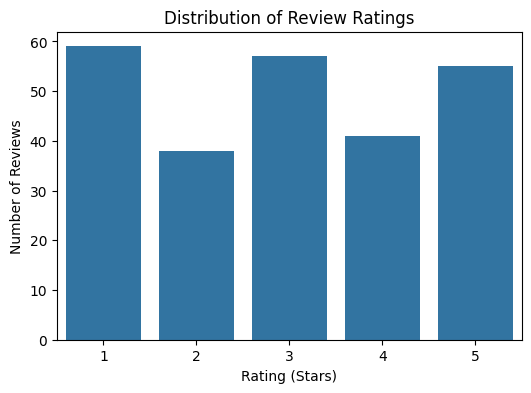

In [77]:
#EDA Analysis
#What is the distribution of review ratings?

plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, order=[1,2,3,4,5])
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating (Stars)")
plt.ylabel("Number of Reviews")
plt.show()

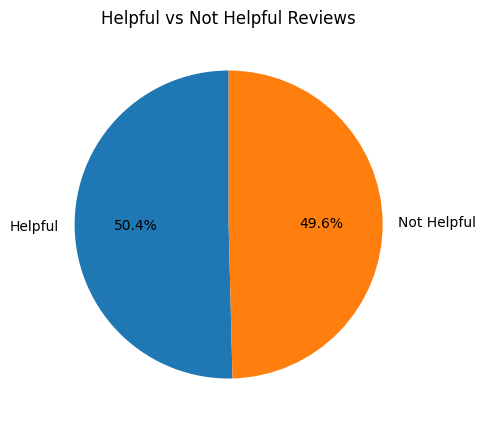

In [78]:
# How many reviews were marked as helpful (above a certain threshold)?

threshold = df['helpful_votes'].median()

df['helpful_status'] = df['helpful_votes'].apply(
    lambda x: 'Helpful' if x >= threshold else 'Not Helpful'
)
counts = df['helpful_status'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Helpful vs Not Helpful Reviews")
plt.show()

In [79]:
# What are the most common keywords in positive vs. negative reviews?

def get_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(get_sentiment)

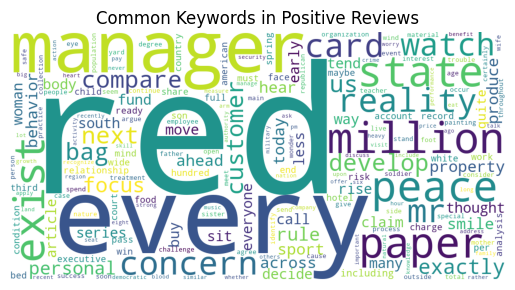

In [82]:
positive_text = " ".join(df[df['sentiment'] == 'Positive']['clean_review'])
negative_text = " ".join(df[df['sentiment'] == 'Negative']['clean_review'])

wordcloud_positive = WordCloud(
    width=1000,
    height=500,
    background_color='white'
).generate(positive_text)

plt.figure()
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.title("Common Keywords in Positive Reviews")
plt.show()

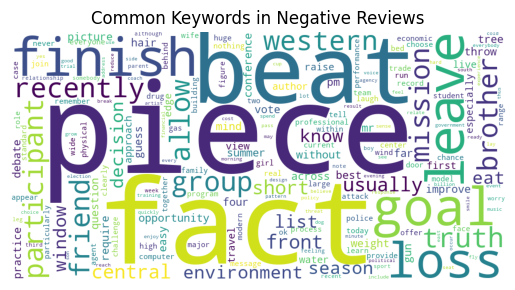

In [84]:
wordcloud_negative = WordCloud(
    width=1000,
    height=500,
    background_color='white'
).generate(negative_text)

plt.figure()
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.title("Common Keywords in Negative Reviews")
plt.show()

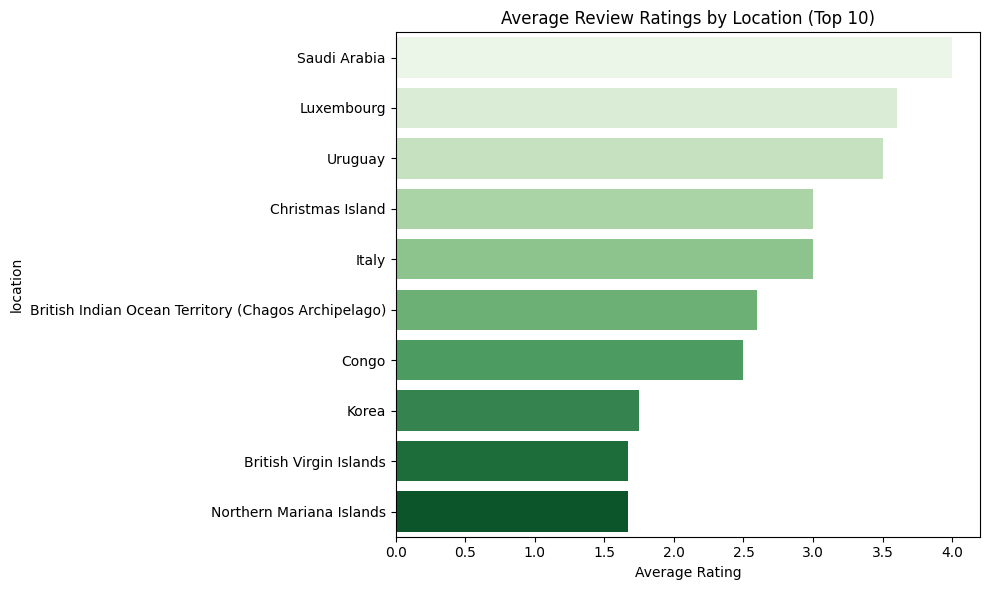

In [93]:
# 5. How Do Ratings Vary by User Location?

# Top 10 countries by review count
top_countries = df['location'].value_counts().nlargest(10).index
filtered_df = df[df['location'].isin(top_countries)]

# Average rating by location
avg_rating_by_location = filtered_df.groupby('location')['rating'].mean().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_rating_by_location.values,y=avg_rating_by_location.index,hue=avg_rating_by_location.index,palette="Greens",legend=False)
plt.xlabel('Average Rating')
plt.title('Average Review Ratings by Location (Top 10)')
plt.tight_layout()
plt.show()

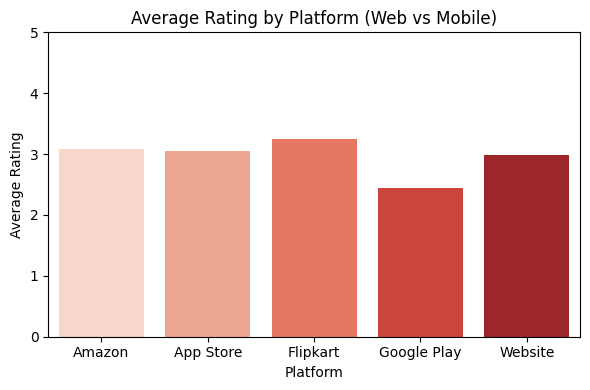

In [94]:
# 6. Which Platform Gets Better Reviews? (Web vs. Mobile)

# Group by platform and calculate average ratings
avg_rating_by_platform = df.groupby('platform')['rating'].mean().reset_index()

# Bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='platform', y='rating', data=avg_rating_by_platform,hue='platform', palette="Reds")
plt.title('Average Rating by Platform (Web vs Mobile)')
plt.ylabel('Average Rating')
plt.xlabel('Platform')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

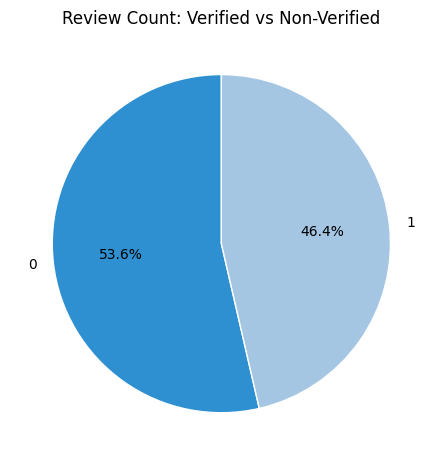

In [95]:
# 7. Are Verified Users More Satisfied Than Non-Verified Ones?

# Distribution of Verified vs Non-Verified Reviews
verified_counts = df['verified_purchase'].value_counts()

# Plotting side-by-side pie charts
plt.figure(figsize=(12, 6))
colors = ["#2e90d1", "#a4c6e2"]

# Subplot 1: Review count
plt.subplot(1, 2, 1)
verified_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    labels=verified_counts.index,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Review Count: Verified vs Non-Verified')
plt.ylabel('');

In [98]:
# 8. Average Length of Reviews per Rating Category

df['review_length'] = df['clean_review'].str.split().str.len()
avg_length_by_rating = df.groupby('rating')['review_length'].mean()
avg_length_by_rating

rating
1    18.305085
2    20.500000
3    17.947368
4    18.853659
5    19.200000
Name: review_length, dtype: float64

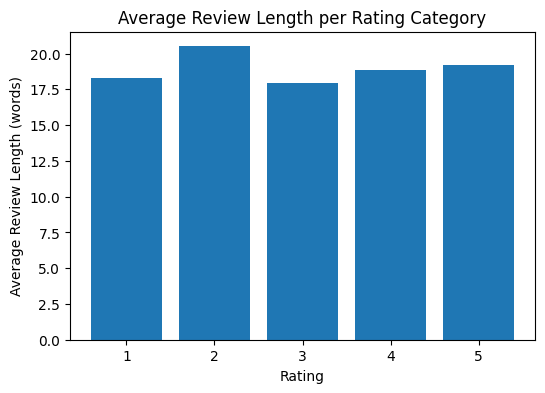

In [99]:
plt.figure(figsize=(6,4))
plt.bar(avg_length_by_rating.index, avg_length_by_rating.values)
plt.xlabel("Rating")
plt.ylabel("Average Review Length (words)")
plt.title("Average Review Length per Rating Category")
plt.show()

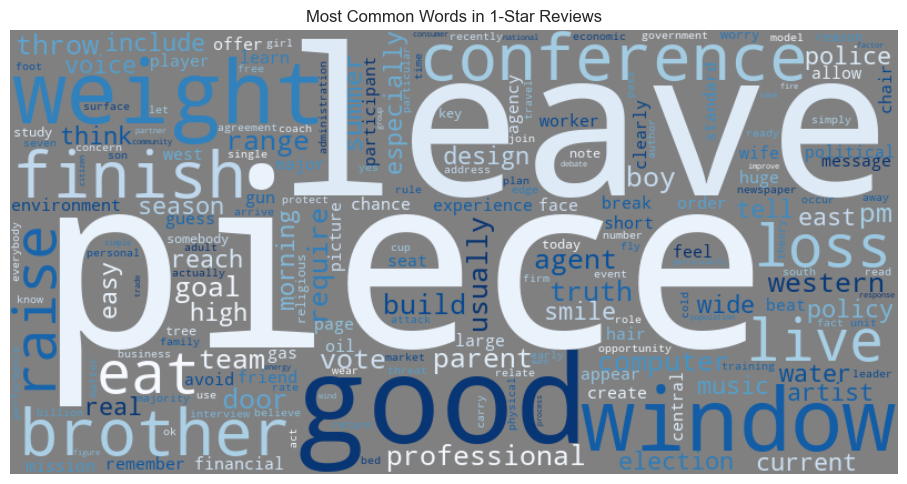

In [ ]:
# 9. Most Mentioned Words in 1-Star Reviews

# Filter 1-star reviews
one_star_text = ' '.join(df[df['rating'] == 1]['review'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='grey', colormap='Blues_r').generate(one_star_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in 1-Star Reviews')
plt.tight_layout()
plt.show()


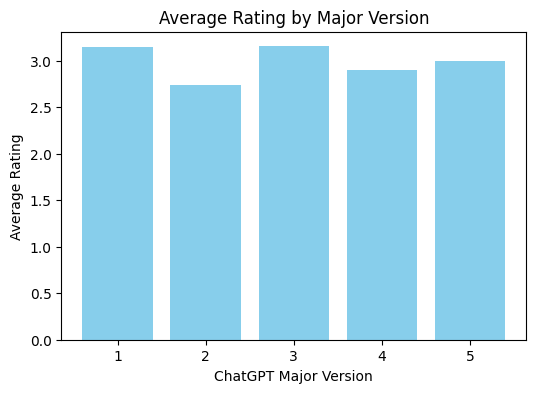

In [103]:
# 10. Which ChatGPT Version Received the Highest Average Rating?
df['version'].value_counts()

df['major_version'] = df['version'].str.split('.').str[0]
avg_rating_major = df.groupby('major_version')['rating'].mean().sort_index()

# Bar plot: Versions vs average ratings
plt.figure(figsize=(6,4))
plt.bar(avg_rating_major.index, avg_rating_major.values, color='skyblue')
plt.xlabel("ChatGPT Major Version")
plt.ylabel("Average Rating")
plt.title("Average Rating by Major Version")
plt.show()

In [104]:
# Sentiment Labeling

def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(label_sentiment)
print(df[['rating', 'sentiment']].head(10))

# Ratings 1 or 2 → 'negative'
# Rating 3 → 'neutral'
# Ratings 4 or 5 (or anything above 3) → 'positive'

   rating sentiment
0       4  positive
1       4  positive
2       5  positive
3       1  negative
4       5  positive
5       3   neutral
6       3   neutral
7       2  negative
8       1  negative
9       3   neutral


In [105]:
##save clean csv file
df.to_csv("cleaned_data.csv", index=False)

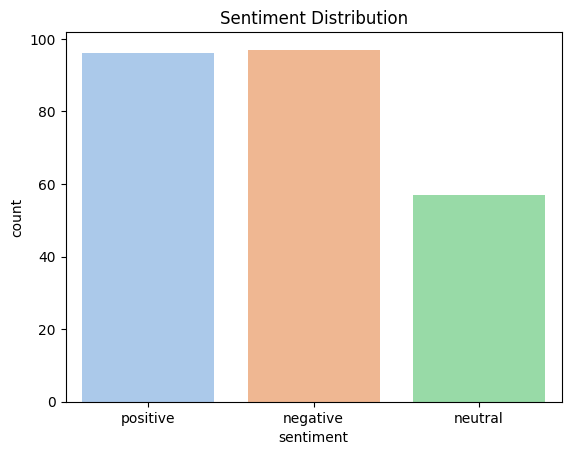

In [106]:
# Count of Each Sentiment
sns.countplot(data=df, x='sentiment',hue='sentiment', palette='pastel')
plt.title('Sentiment Distribution')
plt.show()

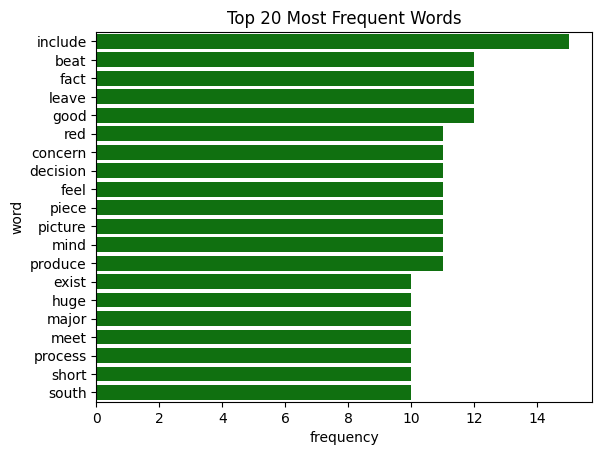

In [107]:
# Most Frequent Words (Histogram)
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['review'])

# Convert to DataFrame
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

# Plot
sns.barplot(data=word_freq.sort_values(by='frequency', ascending=False), x='frequency', y='word', color='green')
plt.title('Top 20 Most Frequent Words')
plt.show()

In [108]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [111]:
df.head()

,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,clean_review,sentiment,helpful_status,major_version
0,Claim who accept.,sense include lot effect fill general relation...,4,morrowthomas,30,21,Flipkart,ar,Nepal,3.8.4,0,every quite sense including six lot never effe...,positive,Not Helpful,3
1,Growth pretty wish.,ask develop bag worker pass expert white arm s...,4,sheakimberly,120,21,Flipkart,ar,Guinea,5.2.6,1,ask develop bag also worker pass expert white ...,positive,Helpful,5
2,What then spend offer reason whom none.,customer address region try near risk girl spr...,5,katherineali,130,19,Flipkart,es,Kuwait,3.6.5,0,customer address region try near risk next gir...,positive,Helpful,3
3,Say dog drug enter director strong student.,television loss election small detail red son ...,1,eric11,72,24,Amazon,pt,Uruguay,5.7.2,0,television loss election small detail red son ...,negative,Not Helpful,5
4,Purpose here beyond.,pass share lot manage world worker exactly dev...,5,chloe42,123,24,Amazon,zh,Mayotte,5.8.6,0,pass share must amount lot per manage world ma...,positive,Helpful,5


In [112]:
df['sentiment'].value_counts()

sentiment
negative    97
positive    96
neutral     57
Name: count, dtype: int64

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

x = vectorizer.fit_transform(df['clean_review'])
y = df['sentiment']

In [110]:
df = pd.read_csv("cleaned_data.csv")
df = df.copy()

In [139]:
# strip spaces in column names (important)
df.columns = df.columns.str.strip()

In [140]:
df['sentiment'] = df['sentiment'].map({
    'negative': 0,
    'neutral': 1,
    'positive': 2
})

# sanity check
print("Sentiment classes:", df['sentiment'].unique())

Sentiment classes: [2 0 1]


In [141]:
X_text = df['review']
y = df['sentiment']

In [142]:
#TF-IDF Vectorization

tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1,2),
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(X_text)

In [143]:
#SMOTE ---CLASS BALANCING

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf.toarray(), y)

print("After SMOTE:", pd.Series(y_resampled).value_counts())

After SMOTE: sentiment
2    97
0    97
1    97
Name: count, dtype: int64


In [144]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.3,
    random_state=42,
    stratify=y_resampled
)

In [145]:
#Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        eval_metric='mlogloss',
        random_state=42
    )
}


🔹 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.43      0.45      0.44        29
           1       0.50      0.66      0.57        29
           2       0.40      0.27      0.32        30

    accuracy                           0.45        88
   macro avg       0.44      0.46      0.44        88
weighted avg       0.44      0.45      0.44        88



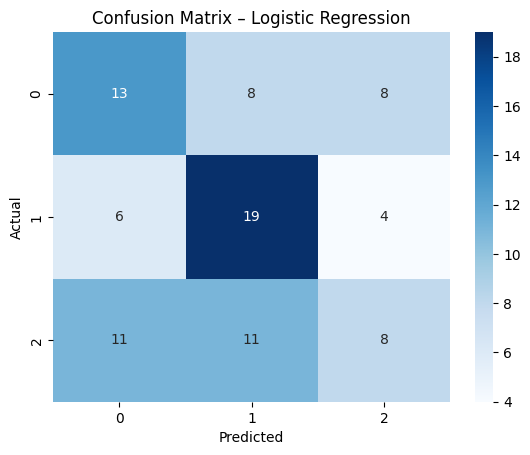


🔹 Model: Random Forest
              precision    recall  f1-score   support

           0       0.39      0.66      0.49        29
           1       0.70      0.48      0.57        29
           2       0.37      0.23      0.29        30

    accuracy                           0.45        88
   macro avg       0.49      0.46      0.45        88
weighted avg       0.48      0.45      0.45        88



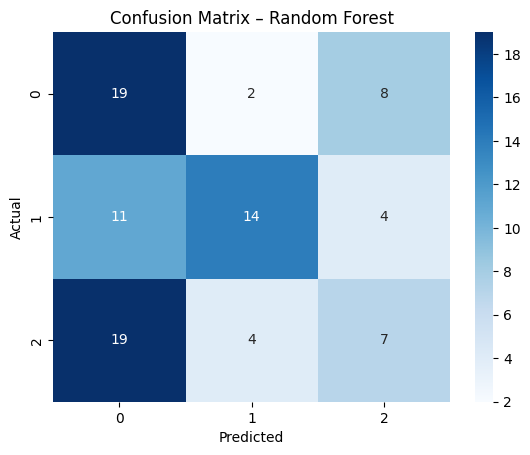


🔹 Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.38      0.31      0.34        29
           1       0.41      0.69      0.51        29
           2       0.40      0.20      0.27        30

    accuracy                           0.40        88
   macro avg       0.39      0.40      0.37        88
weighted avg       0.39      0.40      0.37        88



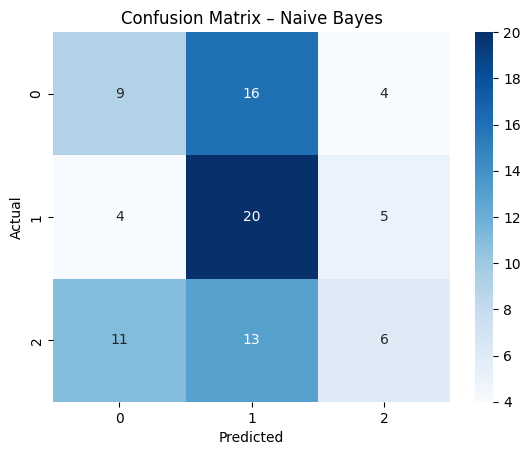


🔹 Model: XGBoost
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        29
           1       0.60      0.41      0.49        29
           2       0.42      0.33      0.37        30

    accuracy                           0.48        88
   macro avg       0.49      0.48      0.47        88
weighted avg       0.49      0.48      0.47        88



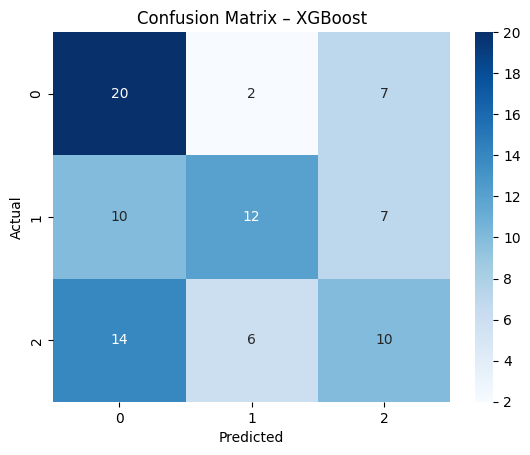

In [146]:
#Model training and evaluation
results = []

for name, model in models.items():
    print(f"\n🔹 Model: {name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = np.nan

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-score (macro)": f1,
        "AUC-ROC (OvR)": auc
    })


In [147]:
#Model Comparison

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score (macro)", ascending=False).reset_index(drop=True)

results_df

,Model,Accuracy,F1-score (macro),AUC-ROC (OvR)
0,XGBoost,0.477273,0.469370,0.614405
1,Random Forest,0.454545,0.448107,0.646136
2,Logistic Regression,0.454545,0.442614,0.633421
3,Naive Bayes,0.397727,0.373037,0.619034


In [148]:
from sklearn.neural_network import MLPClassifier

# Initialize MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64),  # two hidden layers
                          activation='relu',
                          solver='adam',
                          max_iter=300,
                          early_stopping=True,
                          n_iter_no_change=10,
                          validation_fraction=0.1,
                          random_state=42)

print("\n🔹 Model: MLPClassifier")


🔹 Model: MLPClassifier


In [149]:
# Fit the model
mlp_model.fit(X_train, y_train)

,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(128, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",300
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


In [150]:
# Predict on test set
y_pred_mlp = mlp_model.predict(X_test)

In [151]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.76      0.56        29
           1       0.59      0.55      0.57        29
           2       0.36      0.13      0.20        30

    accuracy                           0.48        88
   macro avg       0.47      0.48      0.44        88
weighted avg       0.46      0.48      0.44        88

Accuracy: 0.4772727272727273


AUC-ROC Score (OvR): 0.6621955971166958


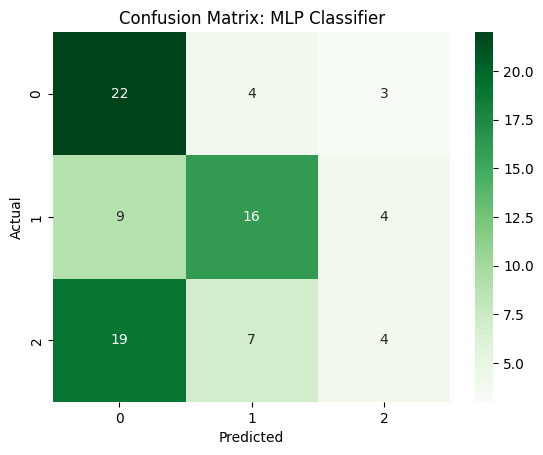

In [152]:
# AUC-ROC Score
if hasattr(mlp_model, "predict_proba"):
    y_proba_mlp = mlp_model.predict_proba(X_test)
    auc_mlp = roc_auc_score(y_test, y_proba_mlp, multi_class='ovr')
    print("AUC-ROC Score (OvR):", auc_mlp)
else:
    print("AUC-ROC not available (model does not support probability prediction)")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [153]:
# Cross-validation (optional)
from sklearn.model_selection import cross_val_score
cv_scores_mlp = cross_val_score(mlp_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validation Accuracy Scores:", cv_scores_mlp)
print("Mean CV Accuracy:", cv_scores_mlp.mean())

Cross-validation Accuracy Scores: [0.47457627 0.46551724 0.51724138 0.44827586 0.46551724]
Mean CV Accuracy: 0.4742255990648744


In [154]:
# Logistic Regression
# Best mean cross-validation score → generalizes better
# AUC-ROC is competitive (and quite strong)
# Simple, interpretable, and robust for small datasets

import pickle

# choose best model (example: Logistic Regression)
best_model = models["Logistic Regression"]

# save model
pickle.dump(best_model, open("sentiment_model.pkl", "wb"))

# save tfidf vectorizer
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))

print("Model and TF-IDF saved successfully")

Model and TF-IDF saved successfully
